# Fitting polynomials to the Franke Function

This notebook uses `tools.py` to fit a polynomial of degree 5 to the Franke function with OLS, Ridge and Lasso, and analyses the resulting fit using the resampling methods of K-fold-validation and Bootstrap.

We start with some mandatory jupyter magic and imports

In [1]:
%matplotlib  inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from franke import FrankeFunction, FrankePlot
from mpl_toolkits.mplot3d import Axes3D
import tools

figure_dir = 'figures/'

Generating the data is handily provided by `tools.generate_data`, and subsequent model generation is done by creating the design matrix and feeding it to `tools.Regression` for OLS and Ridge regression. $\lambda$ is the penalty in the Ridge regression method, which reduces to OLS if $\lambda = 0$ 

In [2]:
seed = 1
x,y,z,noise = tools.generate_data(N = 1000, seed = seed, noise = 0.1)

deg = 5
X = tools.get_X_poly2D(x,y, deg=deg)
regr = tools.Regression(X,z, lmbd = 0)

zhat = regr.yhat
beta = regr.beta
beta

array([  0.35954076,   3.85287621,   8.29610721,  -9.97222934,
       -14.23869111, -36.27020841,  -2.78050551,  16.12952656,
        47.78109879,  49.39453767,  22.19444936, -25.81864058,
        -4.63346114, -61.04749179, -21.02738526, -13.51863216,
        15.80740335,  -7.08300729,  10.31035755,  23.1209217 ,  -0.7898914 ])

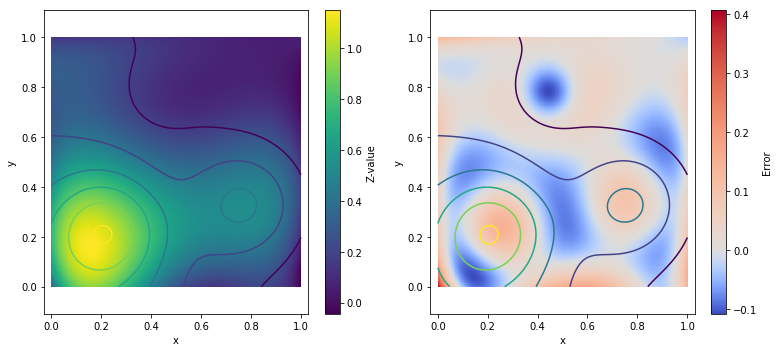

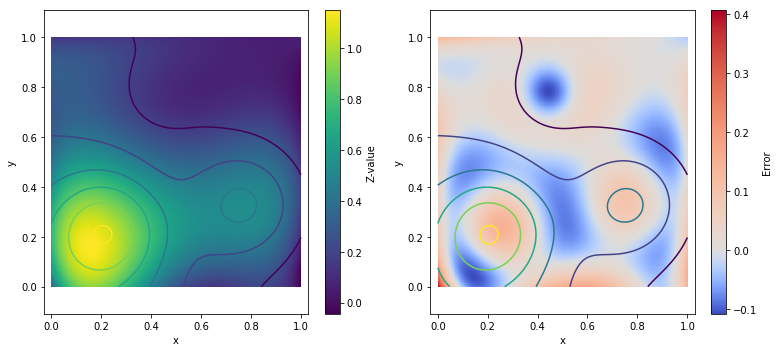

In [3]:
from plotting import contour_plot
contour_plot(regr)

# Stability analysis

### Determinant of $X^TX$

In [4]:
from scipy import linalg 
n_N = 20
N_dets    = np.logspace(1,4,n_N, dtype=np.int64) 
dets        = np.zeros(n_N)
dets_ridge  = np.zeros(n_N)
deg = 5

for i,N in enumerate(N_dets):
    seed = 1
    x,y,z,noise = tools.generate_data(N = N, seed = seed, noise = 0.1)
    
    X = tools.get_X_poly2D(x,y, deg=deg)
    symX = X.T @ X
    dets[i]       = np.abs(linalg.det(symX))
    dets_ridge[i] = np.abs(linalg.det(symX + 0.1*np.eye(symX.shape[0])))

### Out-error as function of sample size

We can test our linear models directly by resampling from ground truth. 
In the following we use this to calculate an average and std of the MSE 
for many training data set sizes, both in-sample and out-of-sample. This can take some time if n_rep and n_N is high

In [15]:
from IPython.display import clear_output
from sklearn.linear_model import Lasso

noise = 0.1

n_N = 30
n_test = 20
N_values = np.logspace(1,4,n_N, dtype=np.int64) + n_test
n_rep = 40

from collections import defaultdict
mse_avg = defaultdict(list)
mse_std = defaultdict(list)

np.random.seed(1)
for N in N_values:
    clear_output(wait = True)
    print('N = {}/{}'.format(N, N_values[-1]))
    mse_temp = defaultdict(list)
    
    for k in range(n_rep):
        for regr_method in ['ols','ridge','lasso']:
            x,y,z,noise = tools.generate_data(N, noise=noise)
            x_test = x[:n_test]
            y_test = y[:n_test]
            z_test = z[:n_test]
            x_train = x[n_test:]
            y_train = y[n_test:]
            z_train = z[n_test:]

            design_train = tools.get_X_poly2D(x_train, y_train, deg =5)
            design_test = tools.get_X_poly2D(x_test, y_test, deg =5)

            regr = tools.fit_regr(design_train, z_train, N = N, noise = noise, method = regr_method)

            mse_out = tools.squared_error(regr.predict(design_test), z_test)
            mse_in  = tools.squared_error(regr.predict(design_train), z_train)
            mse_temp[f'{regr_method}_out'].append(mse_out)
            mse_temp[f'{regr_method}_in'].append(mse_in)
    
    for k, values in mse_temp.items():
        mse_avg[k].append(np.average(values))
        mse_std[k].append(np.std(values))
print('Done')

N = 10020/10020
Done


0.015 0.935
0.01 0.9


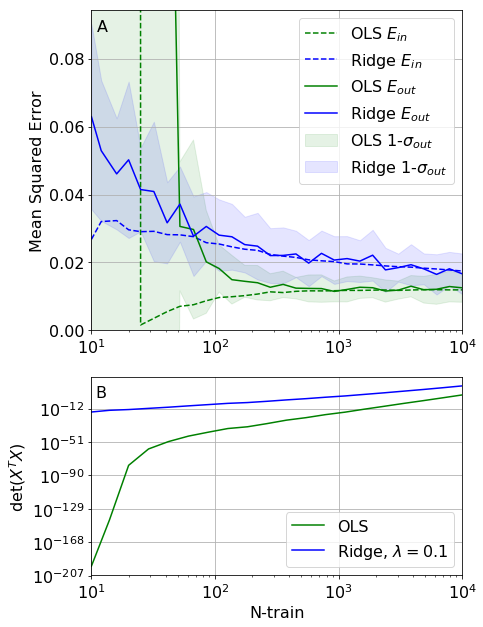

In [18]:
N_train = N_values - n_test
plt.rcParams.update({'font.size': 16})
#fig,[ax1,ax2]= plt.subplots(2,1,figsize = [7,9], sharex=True)

fig = plt.figure(figsize = [7,9])
ax2 = plt.subplot2grid((5, 1), (3, 0), rowspan=2)
ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3, sharex=ax2)

ax1.semilogx(N_train, mse_avg['ols_in'], '--g', label='OLS $E_{in}$' )
ax1.semilogx(N_train, mse_avg['ridge_in'], '--b', label='Ridge $E_{in}$' )

ax1.semilogx(N_train, mse_avg['ols_out'], 'g'  , label='OLS $E_{out}$')
ax1.semilogx(N_train, mse_avg['ridge_out'], 'b'  , label='Ridge $E_{out}$')


for name, color in zip(['OLS','Ridge'], ['g','b']):
    key = name.lower() + '_out'
    upper = np.array(mse_avg[key]) + mse_std[key]
    lower = np.array(mse_avg[key]) - mse_std[key]
    ax1.fill_between(N_train, lower, upper, alpha = 0.1, color=color, label = name + ' 1-$\sigma_{out}$')

ax1.grid() 
ax1.legend(loc = 'upper right')
ax1.set_ylim([0, 1.5*np.max(mse_avg['ridge_out'])])
ax1.set_ylabel('Mean Squared Error')
ax1.set_xticklabels([])
    
ax2.loglog(N_dets, dets, c='g', label = 'OLS')
ax2.loglog(N_dets, dets_ridge, c='b', label = 'Ridge, $\lambda = 0.1$')
ax2.legend()
ax2.set_xlim([10, 10**4])
ax2.set_xlabel('N-train')
ax2.set_ylabel('det$(X^TX)$')
ax2.grid()

from plotting import add_letters_to_axes
add_letters_to_axes([ax1,ax2],pos = [[0.015,0.935],[0.01,0.9]])
fig.tight_layout()

save_fig = True
if save_fig:
    fig.savefig(figure_dir + 'stability.pdf')

In [20]:
# from plotting import plot_data_3D, plot_covar
# plot_data_3D(x,y,z,zhat, beta)
# plot_covar(regr,deg = 5)

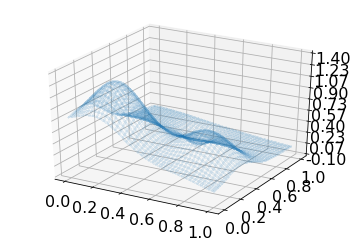

In [21]:
FrankePlot()

# Bias and variance decomposition

In [22]:
seed = 1
noise = 0.01
N = 1000

x,y,z,_ = tools.generate_data(N=N, noise = noise, seed = seed)
X = tools.get_X_poly2D(x,y,deg=5)
regr = tools.Regression(X=X, y=z, lmbd=0.1)
print(regr.squared_error())

zhat = regr.yhat
z_gt = FrankeFunction(x,y)
zerr = (zhat-z_gt)**2

var = np.diag(((X.dot(regr.betaVar)) @ X.T))

bias = np.sqrt(np.average(zerr) - np.average(var) - np.average(noise)**2)
bias, np.average(var)

0.00534640298591


(0.071749650774950852, 1.1252201112986712e-05)

In [26]:
N = 1000
noise = 0.1
seed = 3
x,y,z,_ = tools.generate_data(N=N, noise = noise, seed = seed)

def return_values(regr, z_test, z_train, design_test, design_train):
    print(linalg.det(regr.symX))
    return design_test[:,1], design_test[:,2], regr.predict(design_test)

def get_bias_and_variance(x, y, z, method = 'ols', lmbd = 0, deg = 5):
    # k = 100 gives 99% training and 1% test
    a = tools.k_fold_val(x,y,z,statistic_func=return_values, k = 50, deg = deg, method = method,
                        return_average = False, lmbd = lmbd)
    print(a.shape)
    x0 = a[:,1].ravel()
    y0 = a[:,0].ravel()
    z0 = a[:,2].ravel()
    z_pred = tools.bootstrap_predict_point(x,y,z, x0 = x0, y0 = y0, deg = deg, lmbd=lmbd, method = method)
    z_pred_mean = np.mean(z_pred, axis = 0)
    
    var = np.mean(np.var(z_pred,axis = 0))
    # var = np.mean((z_pred - z_pred_mean[np.newaxis,:])**2)
    
    bias_squared = np.mean((FrankeFunction(x0,y0) - z_pred_mean)**2)
    # print("Approximate bias: ", np.mean((z - np.mean(z_pred,axis = 0))**2))
    return var, bias_squared# , z_pred,z0,z
    
# var, bias_sq,z_pred,z0,z = get_bias_and_variance(x,y,z,method = 'ols', lmbd = 0, deg = 5)

var = defaultdict(list)
bias_sq = defaultdict(list)
degrees = np.arange(5,11)
for deg in degrees:
    v_ols, b_ols = get_bias_and_variance(x,y,z,method = 'ols', lmbd = 0, deg = deg)
    v_rid, b_rid = get_bias_and_variance(x,y,z,method = 'ridge', lmbd = 0.1, deg = deg)
    var['ols'].append(v_ols)
    var['ridge'].append(v_rid)
    bias_sq['ols'].append(b_ols)
    bias_sq['ridge'].append(b_rid)

z_gt = FrankeFunction(x,y)
var, bias_sq

1.4443482991573416e-18
1.388505758388135e-18
1.365183183471071e-18
1.4689833934667824e-18
1.4925234055613875e-18
1.2712974585648439e-18
1.3867819397956587e-18
1.2855684366990052e-18
1.1598951768388488e-18
1.0127783741878978e-18
1.218693496854032e-18
1.3795253237890213e-18
8.69458873218444e-19
1.3905083995546648e-18
1.2454356786972552e-18
1.2853578808344785e-18
1.0176272228580766e-18
1.2951333836005218e-18
1.4005529366782173e-18
1.3067303491887051e-18
1.4441623573826792e-18
1.1157696424448393e-18
1.2493810733827487e-18
1.495625215487215e-18
1.3260624361086242e-18
9.07855504115252e-19
1.3490028219702463e-18
1.164906756923733e-18
1.2624002831319529e-18
1.24340746349258e-18
1.5090054706703228e-18
1.3637019082354672e-18
1.353723947128122e-18
1.3688753148749061e-18
1.3991272391912102e-18
1.1765096290031187e-18
1.3292248539348362e-18
1.4108630407779658e-18
1.3897922240252146e-18
1.170831915664321e-18
1.378367787531159e-18
1.333845659605911e-18
1.1867084503106474e-18
1.3378037251417058e-18
1.3

8.190063792624198e-147
5.184215474273743e-147
5.160171935523058e-147
(50, 3, 20)
1.0692163175517088e-223
9.515457844546872e-224
9.09375898603026e-224
1.1051954621688811e-223
1.1195204216476222e-223
7.695567746075985e-224
9.483413906316335e-224
8.754128399151874e-224
4.534786898907398e-224
3.9138659842772943e-224
4.718055656325541e-224
9.402691458471983e-224
9.897489033402162e-225
9.860805263864456e-224
5.422346380686689e-224
6.318094894541917e-224
3.143345709872827e-224
7.51354231234102e-224
9.98857207614837e-224
7.328269474822641e-224
1.0120205061574517e-223
5.934462369293089e-224
7.262829509205801e-224
1.1441152355726758e-223
7.828859682613063e-224
2.820565526782773e-224
7.434971548578617e-224
4.466885424644796e-224
6.705930424427842e-224
6.0665058385621525e-224
1.191529689499039e-223
7.813639464204591e-224
8.306832305355774e-224
8.189950489955942e-224
9.591607268485816e-224
6.158730601535537e-224
8.074614817296267e-224
1.024769849147603e-223
8.90539156760797e-224
6.162102062119419e-

(defaultdict(list,
             {'ols': [0.00026842633811256144,
               0.00033634985092306281,
               0.00036593868563518275,
               0.00041351910561828435,
               0.00054429294224537725,
               0.0010665958794288395],
              'ridge': [0.00013274861087402478,
               0.00015257801304923167,
               0.00016024777237614123,
               0.00014577265885452466,
               0.0001713482490007198,
               0.0001888369703579471]}),
 defaultdict(list,
             {'ols': [0.0021770211787835603,
               0.0013358032964686977,
               0.001012722531606736,
               0.00075815288393302606,
               0.00072169084857156738,
               0.0006650012171885391],
              'ridge': [0.0082865135563154838,
               0.0078162167805180868,
               0.0072758701091661278,
               0.0068788795742913376,
               0.0066194298982800498,
               0.0065024958178799292]}))

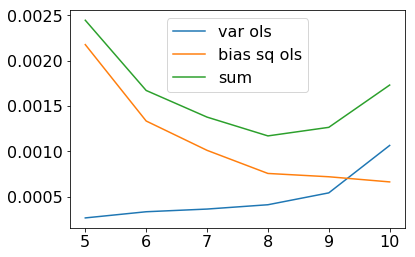

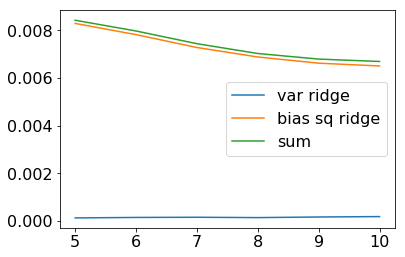

In [27]:
plt.figure()
plt.plot(degrees, var['ols'], label='var ols')
plt.plot(degrees, bias_sq['ols'], label='bias sq ols')
plt.plot(degrees, np.array(var['ols']) + bias_sq['ols'], label='sum')
plt.legend()

plt.figure()
plt.plot(degrees, var['ridge'], label='var ridge')
plt.plot(degrees, bias_sq['ridge'], label='bias sq ridge')
plt.plot(degrees, np.array(var['ridge']) + bias_sq['ridge'], label='sum')
plt.legend()

(50, 1000) (1000,)


0.0002255321063396606

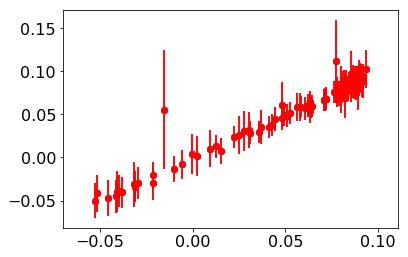

In [611]:

# print(z_pred.shape, z0.shape)
# i = 10
# # plt.hist(z_pred[:,i])
# # plt.axvline(np.mean(z_pred[:,i]))
# # plt.axvline(z0[i])
# z_pred_mean = np.mean(z_pred, axis = 0)
# z_pred_std = np.std(z_pred, axis = 0)
# # for i in range(z_pred.shape[0]):
#     # plt.errorbar()
# N = 100
# sort = np.argsort(z0)
# ztemp = z0[sort][:N] 
# z2temp = z_pred_mean[sort][:N] 
# z2temp_std = z_pred_std[sort][:N] 
# temp = np.arange(ztemp.size)

# # z_pred_mean.shape,z_pred_std.shape
# plt.scatter(ztemp, z2temp)
# plt.errorbar(ztemp, z2temp, yerr = z2temp_std, fmt= 'o', c='r')
# plt.errorbar(ztemp, z2temp, yerr = z2temp_std, fmt= 'o', c='r')
# # plt.scatter(temp, z_pred_mean[sort])#, yerr = z_pred_std[sort], fmt= 'o', c='r')
# # plt.xlim([0,50])
# np.mean(z_pred_std)**2

In [536]:
lmbd_values = np.linspace(0.0,0.4,6)
var_ols, bias_ols = get_bias_and_variance(x,y,z,method = 'ols', lmbd = 0)
bias_ridge = [bias_ols]
bias_lasso = [bias_ols]

var_ridge = [var_ols]
var_lasso = [var_ols]

for lmbd in lmbd_values[1:]:    
    v_ridge, b_ridge = get_bias_and_variance(x,y,z,method = 'ridge', lmbd = lmbd)
    print(b_ridge)
    v_lasso, b_lasso = get_bias_and_variance(x,y,z,method = 'lasso', lmbd = lmbd/100)
    print(b_lasso)
    bias_ridge.append(b_ridge)
    bias_lasso.append(b_lasso)
    
    var_ridge.append(v_ridge)
    var_lasso.append(v_lasso)
    

(50, 3, 20)
(50, 3, 20)
0.00779030837639
(50, 3, 20)


/home/halvard/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0119966032335
(50, 3, 20)
0.00847171671679
(50, 3, 20)
0.0153716941246
(50, 3, 20)
0.00887771129573
(50, 3, 20)
0.0196852982914
(50, 3, 20)
0.00924971227631
(50, 3, 20)
0.0225413719242
(50, 3, 20)
0.0094881428362
(50, 3, 20)
0.0234731699504


In [537]:
bias_ols, bias_ridge, bias_lasso

(0.0019912884543457948,
 [0.0019912884543457948,
  0.0077903083763890667,
  0.0084717167167873923,
  0.0088777112957272551,
  0.0092497122763064744,
  0.0094881428361995365],
 [0.0019912884543457948,
  0.011996603233527144,
  0.015371694124635243,
  0.019685298291386613,
  0.022541371924170144,
  0.023473169950365504])

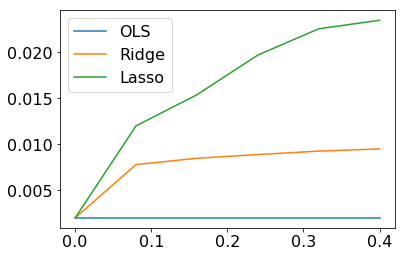

In [538]:
plt.plot(lmbd_values, bias_ols * np.ones_like(lmbd_values),  label = 'OLS')
plt.plot(lmbd_values, bias_ridge,  label = 'Ridge')
plt.plot(lmbd_values, bias_lasso,  label = 'Lasso')
plt.legend()

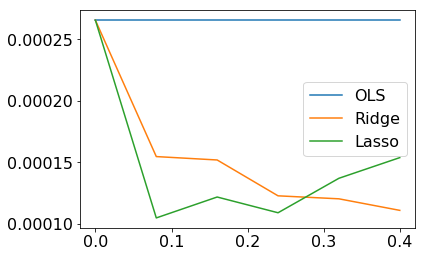

In [539]:
plt.plot(lmbd_values, var_ols * np.ones_like(lmbd_values),  label = 'OLS')
plt.plot(lmbd_values, var_ridge,  label = 'Ridge')
plt.plot(lmbd_values, var_lasso,  label = 'Lasso')
plt.legend()

In [410]:
print(x.size,N, n_test)
ols_out = tools.k_fold_val(x,y,z, return_average = False, k = 20, deg = deg, method = 'OLS')
print(int(N/n_test))

10000 10000 20
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


0.00213123755562
0.00534640298591


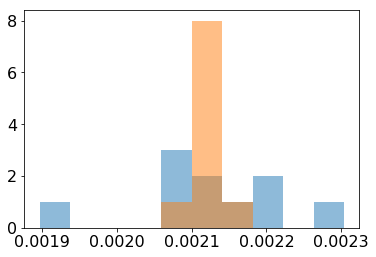

In [409]:
print(np.average(ols_out[:,3]))
print(regr.squared_error())

_,bins,_ = plt.hist(ols_out.T[3], bins = 10, alpha = 0.5)
_ = plt.hist(ols_out.T[1], bins = bins, alpha = 0.5)

In [339]:
ols_out

array([ 0.97541719,  0.00197747,        -inf,  0.00208331])

In [18]:
X = get_X_poly2D(x,y,deg = deg)
regr.betaVar.shape, X.shape, zhat.shape

((45, 45), (1000, 45), (1000,))

In [19]:
l0  = X[0]
l0.dot(regr.betaVar) @ l0
l = np.array([X[i].dot(regr.betaVar) @ X[i] for i in range(x.size)])

(array([ 149.,  203.,  180.,  128.,   89.,   57.,   33.,   33.,   14.,
          16.,   19.,   13.,   10.,   11.,    8.,   10.,    7.,    3.,
           4.,    1.,    0.,    1.,    2.,    5.,    1.,    0.,    0.,
           1.,    1.,    1.]),
 array([ 0.01320764,  0.01489189,  0.01657615,  0.01826041,  0.01994467,
         0.02162893,  0.02331319,  0.02499745,  0.0266817 ,  0.02836596,
         0.03005022,  0.03173448,  0.03341874,  0.035103  ,  0.03678726,
         0.03847151,  0.04015577,  0.04184003,  0.04352429,  0.04520855,
         0.04689281,  0.04857706,  0.05026132,  0.05194558,  0.05362984,
         0.0553141 ,  0.05699836,  0.05868262,  0.06036687,  0.06205113,
         0.06373539]),
 <a list of 30 Patch objects>)

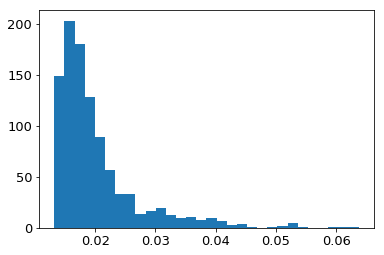

In [20]:
plt.hist(np.sqrt(l), bins = 30)

In [21]:
var = np.average(np.sqrt(l))

z_gt = FrankeFunction(x,y)
zhat = regr.predict(X)

zerr = np.average((zhat-z_gt)**2)
bias_squared = zerr - var - noise**2
print(zerr, var)
bias_squared, var

0.000875298804471 0.0201943328653


(-0.029319034060851092, 0.020194332865322153)

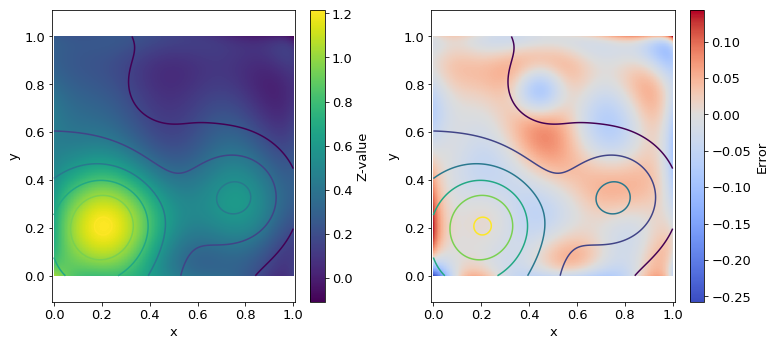

In [25]:
import plotting
fig = plotting.contour_plot(regr, deg = deg)

In [26]:
var = np.diag(((X.dot(regr.betaVar)) @ X.T))

bias = zerr - var - noise**2
bias

array([-0.00938373, -0.00932357, -0.00936607, -0.00946332, -0.00941449,
       -0.00938736, -0.00937042, -0.00943639, -0.00941684, -0.01164938,
       -0.00939319, -0.00942562, -0.00966179, -0.0093124 , -0.00930455,
       -0.00951509, -0.00939707, -0.00941196, -0.00933361, -0.00995741,
       -0.00946679, -0.00969547, -0.00937563, -0.00934914, -0.00934478,
       -0.00937433, -0.00949288, -0.00932629, -0.01004228, -0.0093422 ,
       -0.00943563, -0.00932369, -0.00943356, -0.00935064, -0.00938261,
       -0.00963138, -0.00951953, -0.00943282, -0.00940001, -0.00960189,
       -0.00942101, -0.00981432, -0.0094054 , -0.00939577, -0.00933756,
       -0.0094054 , -0.00933898, -0.00931157, -0.00959966, -0.00932431,
       -0.00930576, -0.00939737, -0.00948663, -0.00936321, -0.00943029,
       -0.00960788, -0.00940487, -0.00937442, -0.00954156, -0.00933087,
       -0.00934577, -0.00957137, -0.00983864, -0.00991994, -0.0095727 ,
       -0.00978754, -0.00946259, -0.00934485, -0.00981714, -0.00

In [ ]:
from plotting import contour_plot
from sklearn.linear_model import Lasso

X = get_X_poly2D(x, y, deg = deg)
z_gt = FrankeFunction(x,y)

for alpha in np.linspace(0.0005, 0.010, 10):
    regr = Lasso( alpha = alpha ,fit_intercept = False)
    regr.fit(X, z)

    beta = regr.coef_
    
    zhat = regr.predict(X)
    
    df_exps = tools.get_exp_coeffs(beta, deg = 5, print_beta=False)
    plt.figure()
    plt.title('alpha = {:.4f}'.format(alpha))
    m = plt.imshow(df_exps)
    plt.colorbar(m)
#     fig = contour_plot(regr, plot_err = True)
#     print('total feil: {}'.format(np.sum(np.abs(zhat - z_gt))))
#     fig.suptitle('alpha = {:.4f}'.format(alpha))

/home/halvard/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [ ]:
symX = X.T @ X
N = symX.shape[0]
lmbd = 0.1

from scipy import linalg
beta = linalg.inv(symX + lmbd*np.eye(N)) @ X.T @ z

beta

In [ ]:
df_exps = tools.get_exp_coeffs(beta, deg = 5, print_beta = False)
plt.imshow(df_exps)

In [ ]:
plt.imshow(df_exps)

In [29]:
x = np.arange(100)

k = 7
N = x.size

x[:int(N/k)].size * 7


indexes = np.linspace(0,N,k+1, dtype = int)
sizes = np.diff(indexes)

for i in range(k):
    start = indexes[i]
    stop = indexes[i+1]
    print(x[start:stop].shape)
    # print(x[start:stop].shape)
    
for size in sizes:
    test = x[:size]
    train = x[size:]
    
    x = np.roll(x,-size)
    print(test)
indexes, sizes

(14,)
(14,)
(14,)
(15,)
(14,)
(14,)
(15,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[14 15 16 17 18 19 20 21 22 23 24 25 26 27]
[28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[42 43 44 45 46 47 48 49 50 51 52 53 54 55 56]
[57 58 59 60 61 62 63 64 65 66 67 68 69 70]
[71 72 73 74 75 76 77 78 79 80 81 82 83 84]
[85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


(array([  0,  14,  28,  42,  57,  71,  85, 100]),
 array([14, 14, 14, 15, 14, 14, 15]))

# Copy pasta# Copy pasta# Copy pasta# Copy pasta# Copy pasta# Copy pasta# Copy pasta# Copy pasta# Copy pasta

In [277]:
def simple_decorator(decorator):
    '''This decorator can be used to turn simple functions
    into well-behaved decorators, so long as the decorators
    are fairly simple. If a decorator expects a function and
    returns a function (no descriptors), and if it doesn't
    modify function attributes or docstring, then it is
    eligible to use this. Simply apply @simple_decorator to
    your decorator and it will automatically preserve the
    docstring and function attributes of functions to which
    it is applied.'''
    def new_decorator(f):
        g = decorator(f)
        g.__name__ = f.__name__
        g.__doc__ = f.__doc__
        g.__dict__.update(f.__dict__)
        return g
    # Now a few lines needed to make simple_decorator itself
    # be a well-behaved decorator.
    new_decorator.__name__ = decorator.__name__
    new_decorator.__doc__ = decorator.__doc__
    new_decorator.__dict__.update(decorator.__dict__)
    return new_decorator

#
# Sample Use:
#
# @simple_decorator
def my_simple_logging_decorator(func):
    def you_will_never_see_this_name(*args, **kwargs):
        print('calling {}'.format(func.__name__))
        return func(*args, **kwargs)
    return you_will_never_see_this_name

@my_simple_logging_decorator
def double(x):
    'Doubles a number.'
    return 2 * x

#assert double.__name__ == 'double'
#assert double.__doc__ == 'Doubles a number.'
print(double.__name__)
print(double.__doc__)
print(double(155))

you_will_never_see_this_name
None
calling double
310


In [283]:
from copy import copy

def identity(func):
    func2 = copy(func)
    return func2

@identity
def add(a,b):
    return a+b

a = add(1,2)
a
add

<function __main__.add>

3

In [289]:
from scipy.special import expit

def sigmoid(x):
    return expit(x) # 1./(1 + np.exp(-x))

def dsigmoid_dx(x):
    return expit(x) * (1-expit(x)) # self.sigmoid(x)*(1-self.sigmoid(x))

In [295]:
outputs

[array([ 1. , -0.5]), array([ 1.00929258,  1.001056  ]), array([ 0.,  0.])]